In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np

def append_ext(fn):
    return fn+".jpg"

traindf=pd.read_csv('D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Training_Part3_GroundTruth.csv',dtype=str)
testdf=pd.read_csv('D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Test_v2_Part3_GroundTruth.csv',dtype=str)
traindf['image_id']=traindf['image_id'].apply(append_ext)
testdf['image_id']=testdf['image_id'].apply(append_ext)
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

In [2]:
label=[0]*traindf.shape[0]
for i in range(traindf.shape[0]):
    if traindf['melanoma'][i] == '1.0':
        label[i]='1'
    else:
        label[i]='0'

traindf['label']=label    

#create a label
label=[0]*testdf.shape[0]
for i in range(testdf.shape[0]):
    if testdf['melanoma'][i] == '1.0':
        label[i]='1'
    else:
        label[i]='0'

testdf['label']=label

In [3]:
train_generator=datagen.flow_from_dataframe(dataframe=traindf,
                                            directory='D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Training_Data\\',
                                            x_col='image_id',
                                            y_col='label',
                                            subset='training',
                                            batch_size=32,
                                            seed=42,
                                            shuffle=True,
                                            class_mode='binary',
                                            target_size=(32,32)
                                           )

valid_generator=datagen.flow_from_dataframe(dataframe=traindf,
                                            directory='D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Training_Data\\',
                                            x_col='image_id',
                                            y_col='label',
                                            subset='validation',
                                            batch_size=32,
                                            seed=42,
                                            shuffle=True,
                                            class_mode='binary',
                                            target_size=(32,32)
                                           )

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(dataframe=testdf,
                                                directory='D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Test_v2_Data\\',
                                                x_col='image_id',
                                                y_col=None,
                                                batch_size=32,
                                                seed=42,
                                                shuffle=False,
                                                class_mode=None,
                                                target_size=(32,32)
                                               )

Found 1500 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 600 validated image filenames.


In [4]:
IMG_SIZE = 224

In [5]:
from tensorflow.keras.applications import EfficientNetB0
# Create the base model from the pre-trained model EfficientNet
base_model = EfficientNetB0(include_top=False, weights="imagenet")

In [39]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

NUM_CLASSES=1
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = inputs
model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(NUM_CLASSES, activation="sigmoid", name="pred")(x)

# Compile
model = tf.keras.Model(inputs, outputs, name="EfficientNet")
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
        
        

In [7]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 224, 224, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_1[0][0]            
_______________________________________________________________________________________

In [8]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model.fit(train_generator,
          epochs=10,
          validation_data=valid_generator,
          verbose=1
         )

Epoch 1/10
47/47 [==============================] - 323s 7s/step - loss: 0.7376 - accuracy: 0.7245 - val_loss: 0.6338 - val_accuracy: 0.7420
Epoch 2/10
47/47 [==============================] - 305s 6s/step - loss: 0.5648 - accuracy: 0.7993 - val_loss: 0.6305 - val_accuracy: 0.7420
Epoch 3/10
47/47 [==============================] - 310s 7s/step - loss: 0.6290 - accuracy: 0.7750 - val_loss: 0.6086 - val_accuracy: 0.7420
Epoch 4/10
47/47 [==============================] - 305s 6s/step - loss: 0.5315 - accuracy: 0.8125 - val_loss: 0.7275 - val_accuracy: 0.7420
Epoch 5/10
47/47 [==============================] - 300s 6s/step - loss: 0.4833 - accuracy: 0.8265 - val_loss: 0.7940 - val_accuracy: 0.7420
Epoch 6/10
47/47 [==============================] - 301s 6s/step - loss: 0.4894 - accuracy: 0.8018 - val_loss: 0.6797 - val_accuracy: 0.7460
Epoch 7/10
47/47 [==============================] - 303s 6s/step - loss: 0.5201 - accuracy: 0.8079 - val_loss: 0.5892 - val_accuracy: 0.7420
Epoch 8/10
47

In [9]:
model.evaluate(valid_generator,
               steps=STEP_SIZE_VALID)

15/15 [==============================] - 18s 1s/step - loss: 0.7010 - accuracy: 0.7063


[0.7009896039962769, 0.706250011920929]

In [10]:
test_generator.reset()
pred=model.predict(test_generator,
                   steps=STEP_SIZE_TEST,
                   verbose=1)

18/18 [==============================] - 250s 14s/step


In [60]:
labels_pred=np.where(pred > 0.5, 1, 0)

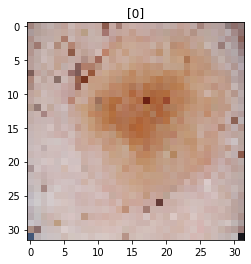

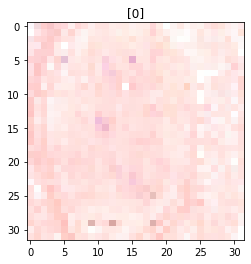

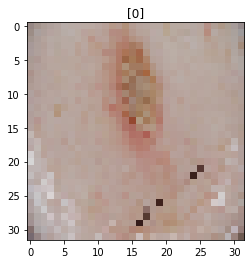

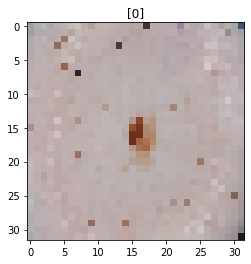

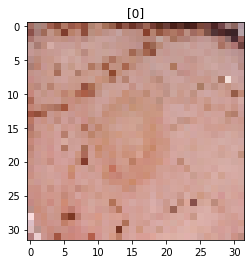

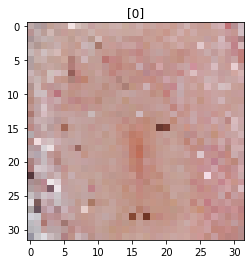

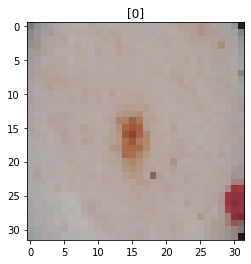

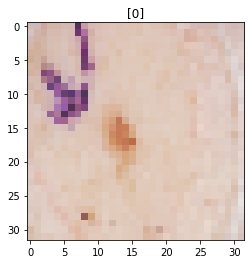

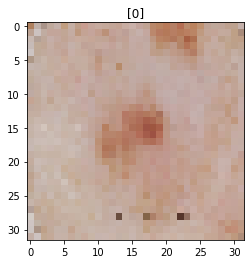

In [125]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
x = test_generator.next() #this unpacks the ImageDataGenerator which is composed by x(image) and y(label). In the case of test, there are not labels
for i in range(9):
    image = x[i]
    plt.title(labels_pred[i])
    plt.imshow(image.astype(np.uint8))
    plt.show()

In [77]:
print(len(test_generator.filenames))
print(len(pred))

600
576


In [76]:
1 in labels_pred #Checking if any of the predictions is for melanoma (label=1)

True

In [110]:
print('Predictions')
print('Melanoma:' + str(np.count_nonzero(labels_pred == 1)))
print('Non-Melanoma:' + str(np.count_nonzero(labels_pred == 0)))

print('\nGround Truth')
print('Melanoma:' + str(np.count_nonzero(testdf['label'] == '1')))
print('Non-Melanoma:' + str(np.count_nonzero(testdf['label'] == '0')))

Predictions
Melanoma:85
Non-Melanoma:491

Ground Truth
Melanoma:117
Non-Melanoma:483


In [129]:
np.where(labels_pred == 1)

(array([ 33,  70,  84,  93, 137, 155, 178, 196, 197, 202, 214, 219, 225,
        229, 233, 242, 245, 248, 255, 256, 260, 262, 265, 266, 276, 279,
        286, 287, 297, 301, 302, 306, 307, 308, 318, 319, 321, 322, 324,
        337, 342, 345, 347, 352, 359, 363, 364, 369, 371, 390, 391, 394,
        399, 401, 407, 408, 409, 428, 431, 435, 436, 437, 438, 439, 444,
        449, 450, 451, 462, 467, 469, 470, 471, 494, 510, 514, 515, 518,
        519, 525, 526, 531, 536, 547, 575], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int64))